In [2]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load marineHeatWaves definition module
import marineHeatWaves as mhw
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors

In [105]:
input_location = ['Maria Island', 'Jervis Bay', 'Jurien', 'Kalbarri']

In [113]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

df_all = pd.read_csv('4pop_change_rawdata.csv')
slopes = []
for loca in input_location:
    df = df_all[df_all.location == loca].reset_index(drop = True)
    
    if loca not in ['Kalbarri']:
        
        ## fit glmm for FULL dataset first
        model_full = smf.mixedlm("survey_change ~ summer_temp_max", df, groups = df["site_name"])
        fit_full = model_full.fit(method='powell')
        slope_full = fit_full.params["summer_temp_max"]
        
        if loca not in ['Jurien']:
            ## repeat sampling  -- bootstrap style
            samples = []
            # Repeat random downsampling 10 times
            for i in range(10):
                sample_i = df.sample(n=92, random_state=i, replace=False)
                sample_i["replicate"] = i  # tag which iteration it came from
                samples.append(sample_i)

            # Combine all replicates into one dataframe
            df_downsampled = pd.concat(samples, ignore_index=True)

            for rep, df_rep in df_downsampled.groupby("replicate"):
                try:
                    # Fit mixed model for each replicate
                    model = smf.mixedlm("survey_change ~ summer_temp_max",
                                        df_rep,
                                        groups=df_rep["site_name"])
                    fit = model.fit(method='powell', reml=False, maxiter=200)

                    # Extract slope and SE
                    slope = fit.params["summer_temp_max"]
                    slope_se = fit.bse["summer_temp_max"]

                    slopes.append({"location": loca,
                                   "replicate": rep,
                                    "slope": slope,
                                    "slope_full": slope_full,
                                    "slope_se": slope_se,
                                    "pval": fit.pvalues["summer_temp_max"]})
                except Exception as e:
                    print(f"Replicate {rep} failed: {e}")

            df_slopes = pd.DataFrame(slopes)    
            mean_slope = df_slopes["slope"][df_slopes.location == loca].mean()
            std_slope  = df_slopes["slope"][df_slopes.location == loca].std()

            print(f"\nMean slope of {loca}: {mean_slope:.3f}, Std: {std_slope:.3f}")   
            
        elif loca in ['Jurien']:
            slopes.append({"location": loca,
                           "slope_full": slope_full})
            df_slopes = pd.DataFrame(slopes) 
    
    else:
        fit_full = sm.OLS(df.survey_change, sm.add_constant(df.summer_temp_max)).fit()
        slope_full = fit_full.params["summer_temp_max"]
        slopes.append({"location": loca,
                       "slope_full": slope_full})
        df_slopes = pd.DataFrame(slopes) 
    
df_slopes


Mean slope of Maria Island: -1.637, Std: 1.372

Mean slope of Jervis Bay: -5.302, Std: 2.046


,location,replicate,slope,slope_full,slope_se,pval
0,Maria Island,0.0,-1.658599,-1.738739,1.293894,0.199890
1,Maria Island,1.0,0.451473,-1.738739,1.644705,0.783699
2,Maria Island,2.0,-2.195026,-1.738739,1.587118,0.166657
3,Maria Island,3.0,-4.533121,-1.738739,1.523877,0.002932
4,Maria Island,4.0,-0.523084,-1.738739,1.340988,0.696482
5,Maria Island,5.0,-2.537561,-1.738739,1.488728,0.088285
6,Maria Island,6.0,-0.334982,-1.738739,1.663157,0.840376
7,Maria Island,7.0,-1.427880,-1.738739,1.506538,0.343237
8,Maria Island,8.0,-1.693812,-1.738739,1.504270,0.260164
9,Maria Island,9.0,-1.917265,-1.738739,1.556766,0.218110


#### plot the distribution of slopes

In [129]:
color_dict = {
    'Maria Island': (9/255, 147/255, 150/255),  # RGB values must be in [0, 1] range
    'Jervis Bay': 'goldenrod',
    'Jurien': (188/255, 62/255, 3/255),
    'Kalbarri': (35/255, 0/255, 25/255)
}
color_dict

{'Maria Island': (0.03529411764705882, 0.5764705882352941, 0.5882352941176471),
 'Jervis Bay': 'goldenrod',
 'Jurien': (0.7372549019607844, 0.24313725490196078, 0.011764705882352941),
 'Kalbarri': (0.13725490196078433, 0.0, 0.09803921568627451)}

Text(0, 0.5, 'Slope of summer temperature effect\n(% per °C)')

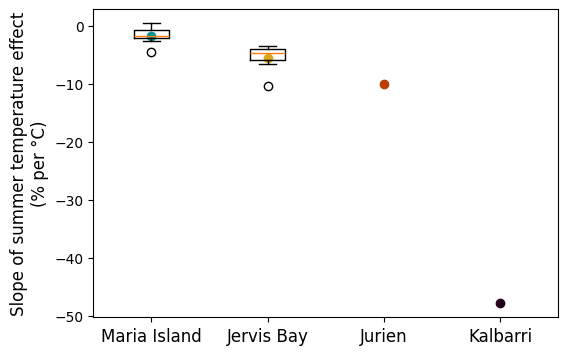

In [137]:
plt.figure(figsize=(6,4))
for i, loca in enumerate(input_location):
    plt.boxplot(df_slopes["slope"][df_slopes.location == loca], positions = [i], widths=0.3)
    plt.scatter([i], df_slopes["slope_full"][df_slopes.location == loca].iloc[0], color=color_dict[loca], label="Full dataset")
    
plt.xticks(range(len(input_location)), input_location, fontsize = 12)
plt.ylabel("Slope of summer temperature effect\n(% per °C)", fontsize = 12)